## Import Libraries

In [1]:
import os
import torch
import pandas as pd
import torchaudio
import pandas as pd
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration, WhisperConfig, WhisperFeatureExtractor
from jiwer import wer
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# Set device
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cpu")
print(device)

cpu


## Utils

In [3]:
def create_file_mapping(transcript_dir, audio_dir):
    """
    Creates a DataFrame mapping transcript files to their corresponding audio files based on filenames.
    
    Args:
        transcript_dir (str): Directory containing transcript text files.
        audio_dir (str): Directory containing audio files.
    
    Returns:
        pd.DataFrame: DataFrame with columns 'Interview', 'Transcript Path', and 'Audio Path'.
    """
    # Get lists of file paths
    transcript_files = [f for f in os.listdir(transcript_dir) if f.endswith('.txt')]
    audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
    
    # Extract file identifiers from filenames
    transcript_ids = {os.path.splitext(f)[0] for f in transcript_files}
    audio_ids = {os.path.splitext(f)[0] for f in audio_files}
    
    # Determine the intersection of transcript and audio IDs
    common_ids = transcript_ids.intersection(audio_ids)
    
    # Create the mapping dictionary
    file_mapping = {
        'Interview': [],
        'Transcript Path': [],
        'Audio Path': []
    }
    
    for file_id in common_ids:
        transcript_path = os.path.join(transcript_dir, file_id + '.txt')
        audio_path = os.path.join(audio_dir, file_id + '.wav')
        file_mapping['Interview'].append(file_id)
        file_mapping['Transcript Path'].append(transcript_path)
        file_mapping['Audio Path'].append(audio_path)
    
    # Convert the dictionary to a DataFrame
    return pd.DataFrame(file_mapping)


def process_transcripts(paths_df):
    """
    Processes transcript files to extract and format relevant data, and combines them into a single DataFrame.
    
    Args:
        paths_df (pd.DataFrame): DataFrame with columns 'Interview', 'Transcript Path', and 'Audio Path'.
    
    Returns:
        pd.DataFrame: DataFrame containing concatenated and processed transcript data.
    """
    all_transcript_data = []
    
    for _, row in paths_df.iterrows():
        transcript_path = row['Transcript Path']
        
        # Load transcript data with appropriate delimiter and columns
        transcript_df = pd.read_csv(transcript_path, delimiter="\t", usecols=['StTime', 'EnTime', 'Content'])
        
        # Convert times from minutes to milliseconds
        transcript_df['StTime'] *= 1000
        transcript_df['EnTime'] *= 1000
        
        # Standardize content to uppercase
        transcript_df['Content'] = transcript_df['Content'].str.upper()
        
        # Add the identifier column
        transcript_df['Interview'] = row['Interview']
        
        # Append to the list
        all_transcript_data.append(transcript_df)
    
    # Combine all transcript data into a single DataFrame
    return pd.concat(all_transcript_data, ignore_index=True)


In [4]:
class AudioDataset(Dataset):
    def __init__(self, df, transcript_dir, audio_dir, processor, target_sample_rate=16000, target_length_ms=15000, padding_value=0):
        """
        Audio Dataset with Padding for ASR tasks.

        Parameters:
        - df (pd.DataFrame): DataFrame containing the dataset information.
        - transcript_dir (str): Directory containing transcript files.
        - audio_dir (str): Directory containing audio files.
        - processor: Processor for audio and text processing.
        - target_sample_rate (int): Target sample rate for audio segments.
        - target_length_ms (int): Target length for audio segments in milliseconds.
        - padding_value (float): Value to use for padding audio segments.
        """
        self.df = df
        self.transcript_dir = transcript_dir
        self.audio_dir = audio_dir
        self.processor = processor
        self.target_sample_rate = target_sample_rate
        self.target_length_samples = int(target_length_ms * target_sample_rate / 1000)
        self.padding_value = padding_value

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        start_tm = row['StTime']
        end_tm = row['EnTime']
        content = row['Content']
        interview = row['Interview']
        audio_path = os.path.join(self.audio_dir, interview + '.wav')
        
        # Extract and process audio segment
        audio_segment = self.extract_audio_segment(audio_path, start_tm, end_tm)
        audio_tensor = self.processor(audio_segment.squeeze().numpy(), sampling_rate=self.target_sample_rate, return_tensors="pt").input_features
        
        # Tokenize and pad transcription
        encodings = self.processor.tokenizer(
            content,
            return_tensors="pt",
            padding='max_length',
            truncation=True,
            max_length=448
        )
        
        labels = encodings.input_ids.squeeze()
        attention_mask = encodings.attention_mask.squeeze()
        
        return {
            'input_features': audio_tensor.squeeze(),
            'labels': labels,
            'attention_mask': attention_mask
        }
    
    def extract_audio_segment(self, audio_file_path, start_time_ms, end_time_ms):
        """
        Extracts and pads a segment from an audio file based on start and end times.
        
        Parameters:
        - audio_file_path (str): Path to the audio file.
        - start_time_ms (int): Start time in milliseconds.
        - end_time_ms (int): End time in milliseconds.
        
        Returns:
        - torch.Tensor: Extracted and padded audio segment.
        """
        waveform, sr = torchaudio.load(audio_file_path)
        
        # Convert milliseconds to sample indices
        start_sample = int(start_time_ms * sr / 1000)
        end_sample = int(end_time_ms * sr / 1000)
        
        # Extract segment and resample if necessary
        segment = waveform[:, start_sample:end_sample]
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=self.target_sample_rate)
            segment = resampler(segment)
        
        # Pad or truncate segment
        return self.pad_audio_segment(segment)
    
    def pad_audio_segment(self, segment):
        """
        Pads or truncates an audio segment to the target length.
        
        Parameters:
        - segment (torch.Tensor): The audio segment to be padded.
        
        Returns:
        - torch.Tensor: Padded or truncated audio segment.
        """
        current_length = segment.size(1)
        if current_length < self.target_length_samples:
            padding_size = self.target_length_samples - current_length
            padding = torch.full((segment.size(0), padding_size), self.padding_value)
            padded_segment = torch.cat((segment, padding), dim=1)
        else:
            padded_segment = segment[:, :self.target_length_samples]
        return padded_segment

In [26]:
# Load your data
root_dir = "/Users/romerocruzsa/Workspace/aiml/final-project-dialect-dynamics"
transcript_dir = root_dir+'/data/coraal/transcript/text/'
audio_dir = root_dir+'/data/coraal/audio/wav/'

paths_df = create_file_mapping(transcript_dir, audio_dir)
combined_transcript_df = process_transcripts(paths_df)
display(combined_transcript_df.sample(10))

,StTime,Content,EnTime,Interview
7374,1497016.6,(PAUSE 2.04),1499057.4,ATL_se0_ag1_f_01_1
21003,1770443.6,(PAUSE 0.82),1771263.4,ATL_se0_ag2_m_02_1
20776,1533689.7,[OKAY.],1534010.7,ATL_se0_ag2_m_02_1
20659,1385299.1,"AIKO, AIKO. I DON'T WANNA FUCK HER NAME UP.",1387592.1,ATL_se0_ag2_m_02_1
9563,80082.1,(PAUSE 0.14),80219.2,ATL_se0_ag2_m_01_1
15736,79382.4,(PAUSE 0.64),80021.3,ATL_se0_ag1_f_03_1
20023,677159.5,AND I DID THE SAME THING IN HIGH SCHOOL. I- UM...,679392.0,ATL_se0_ag2_m_02_1
9580,97469.5,"I DON'T REALLY LIKE USING IT THAT MUCH, YOU KN...",100556.6,ATL_se0_ag2_m_01_1
13401,202767.8,(PAUSE 0.59),203355.6,ATL_se0_ag1_m_04_2
13999,57633.8,(PAUSE 0.14),57774.1,ATL_se0_ag2_f_02_1


In [7]:
# Filter out rows with unwanted characters in the 'Content' column
pattern = r'[\(\)\[\]/<>]'
filtered_transcript_df = combined_transcript_df[~combined_transcript_df['Content'].str.contains(pattern)].reset_index(drop=True)
display(filtered_transcript_df.sample(10))

,StTime,Content,EnTime,Interview
2226,22249.1,OKAY.,22927.9,ATL_se0_ag1_f_01_1
4540,372833.4,THAT'S MY HEART.,373401.6,ATL_se0_ag1_f_02_1
5224,2105468.7,GEORGIA HAS A LOT OF CULTURE.,2107319.6,ATL_se0_ag1_f_02_1
3198,1484546.4,SHIT I EVEN- I'D EVEN LIKE- I'D- I'D- I TRIED ...,1489067.6,ATL_se0_ag1_m_01_1
2423,561175.9,YOU GOT,562050.5,ATL_se0_ag1_f_01_1
9657,1558425.6,SO WHEN- WHEN- YOU CAN ONLY BE SURPRISED ON HO...,1562595.3,ATL_se0_ag1_m_02_1
2359,387633.8,YEP.,388089.8,ATL_se0_ag1_f_01_1
3231,1596492.9,OKAY.,1596992.1,ATL_se0_ag1_m_01_1
3061,1106764.8,A- AND THE NIGGA YOU MIGHT LOOK AND S-,1108733.4,ATL_se0_ag1_m_01_1
6387,2348637.9,GLAD THAT'S YOUR TOPIC OF DISCUSSION.,2350398.9,ATL_se0_ag2_f_02_1


In [8]:
# subset_size = int(len(filtered_transcript_df)*.25)
subset_size = 150
data_subset = filtered_transcript_df.sample(subset_size)
print(len(data_subset))

150


In [9]:
# Split the data into training and testing sets
# train_df, test_df = train_test_split(filtered_transcript_df, test_size=0.2, random_state=42)
train_df, test_df = train_test_split(data_subset, test_size=0.2, random_state=42)

In [10]:
print(f"Train Dataset: {len(train_df)}\t Test Dataset: {len(test_df)}")

Train Dataset: 120	 Test Dataset: 30


In [11]:
# Initialize processor and model
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")
config = WhisperConfig.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en").to(device)

In [12]:
# Create datasets and dataloaders
train_dataset = AudioDataset(train_df, transcript_dir, audio_dir, processor)
test_dataset = AudioDataset(test_df, transcript_dir, audio_dir, processor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [13]:
# Training function
def train(model, train_loader, processor, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    true_transcriptions = []
    predicted_transcriptions = []
    
    for batch in tqdm(train_loader, total=len(train_loader), desc='Training'):
        inputs = batch['input_features'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_features=inputs, labels=labels)
        loss = outputs.loss

        outputs = model.generate(input_features=inputs)
        transcriptions = processor.batch_decode(outputs, skip_special_tokens=True)
        true_transcriptions.extend(processor.batch_decode(labels, skip_special_tokens=True))
        predicted_transcriptions.extend(transcriptions)

        predicted_transcriptions = [x.upper() for x in predicted_transcriptions]
        wer_score = wer(true_transcriptions, predicted_transcriptions)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
    total_loss = total_loss / len(train_loader)
    
    return total_loss, wer_score

def test(model, test_loader, processor, device):
    model.eval()
    total_loss = 0
    true_transcriptions = []
    predicted_transcriptions = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, total=len(test_loader), desc='Testing'):
            inputs = batch['input_features'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_features=inputs, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
            
            outputs = model.generate(input_features=inputs)
            transcriptions = processor.batch_decode(outputs, skip_special_tokens=True)
            true_transcriptions.extend(processor.batch_decode(labels, skip_special_tokens=True))
            predicted_transcriptions.extend(transcriptions)

    total_loss = total_loss / len(test_loader)
    predicted_transcriptions = [x.upper() for x in predicted_transcriptions]
    wer_score = wer(true_transcriptions, predicted_transcriptions)
    
    # Create a DataFrame with the actual and predicted transcriptions
    transcripts = pd.DataFrame({
        'actual': true_transcriptions,
        'predicted': predicted_transcriptions
    })
    
    return transcripts, total_loss, wer_score


In [14]:
# Fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)
num_epochs = 10
train_loss_per_epoch = []
train_wer_per_epoch = []

for epoch in range(num_epochs):
    train_loss, train_wer = train(model, train_loader, processor, optimizer, scheduler, device)
    print(f"Epoch {epoch+1}/{num_epochs}\t Training Loss: {train_loss:.4f}, Word Error Rate (WER): {train_wer:.4f}")
    train_loss_per_epoch.append(train_loss)
    train_wer_per_epoch.append(train_wer)

Training: 100%|██████████| 8/8 [03:00<00:00, 22.59s/it]


Epoch 1/10	 Training Loss: 0.5538, Word Error Rate (WER): 0.4410


Training: 100%|██████████| 8/8 [02:44<00:00, 20.57s/it]


Epoch 2/10	 Training Loss: 0.1323, Word Error Rate (WER): 0.4276


Training: 100%|██████████| 8/8 [02:43<00:00, 20.40s/it]


Epoch 3/10	 Training Loss: 0.1233, Word Error Rate (WER): 0.4290


Training: 100%|██████████| 8/8 [02:39<00:00, 19.90s/it]


Epoch 4/10	 Training Loss: 0.1232, Word Error Rate (WER): 0.4276


Training: 100%|██████████| 8/8 [02:54<00:00, 21.84s/it]


Epoch 5/10	 Training Loss: 0.1219, Word Error Rate (WER): 0.4357


Training: 100%|██████████| 8/8 [02:45<00:00, 20.65s/it]


Epoch 6/10	 Training Loss: 0.1212, Word Error Rate (WER): 0.4357


Training: 100%|██████████| 8/8 [02:47<00:00, 20.92s/it]


Epoch 7/10	 Training Loss: 0.1209, Word Error Rate (WER): 0.4357


Training: 100%|██████████| 8/8 [02:50<00:00, 21.31s/it]


Epoch 8/10	 Training Loss: 0.1198, Word Error Rate (WER): 0.4357


Training: 100%|██████████| 8/8 [02:50<00:00, 21.31s/it]


Epoch 9/10	 Training Loss: 0.1202, Word Error Rate (WER): 0.4357


Training: 100%|██████████| 8/8 [03:05<00:00, 23.22s/it]

Epoch 10/10	 Training Loss: 0.1209, Word Error Rate (WER): 0.4357


In [15]:
test_transcripts, test_loss, test_wer = test(model, test_loader, processor, device)
print(f"Running inference...\t Test Loss: {test_loss:.4f}, Word Error Rate (WER): {test_wer:.4f}")

Testing: 100%|██████████| 2/2 [00:20<00:00, 10.32s/it]

Running inference...	 Test Loss: 0.1197, Word Error Rate (WER): 0.3503


In [24]:
def visualizing_wordcloud(transcripts):
    # Combine all actual and predicted transcriptions into single text
    true_text = ' '.join(transcripts['actual'].str.lower())
    pred_text = ' '.join(transcripts['predicted'].str.lower())

    # Generate word clouds
    true_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(true_text)
    pred_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(pred_text)

    # Plotting the word clouds
    plt.figure(figsize=(7, 7))
    
    # Actual word cloud
    plt.subplot(2, 1, 1)
    plt.imshow(true_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for True Transcriptions')
    plt.axis('off')
    
    # Predicted word cloud
    plt.subplot(2, 1, 2)
    plt.imshow(pred_wordcloud, interpolation='bilinear')
    plt.title('Word Cloud for Predicted Transcriptions')
    plt.axis('off')

    plt.show()

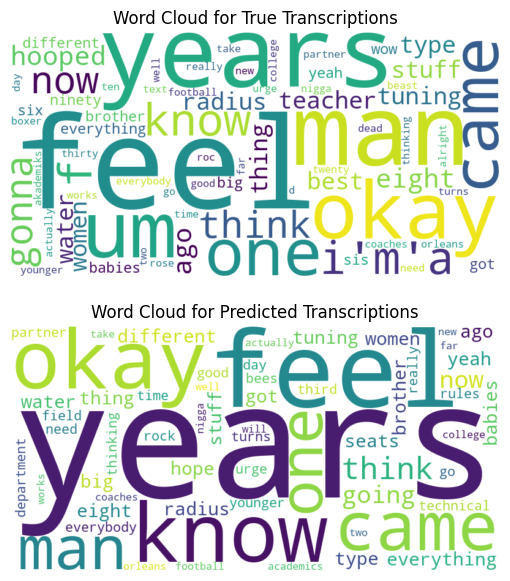

In [25]:
visualizing_wordcloud(test_transcripts)

In [27]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S') # Format: YYYY-MM-DD_HH:MM:SS
weights_filepath = root_dir+"/weights/whisper-weights_"

torch.save(model.state_dict(), weights_filepath+timestamp)
print(f"Model weights saved to {weights_filepath+timestamp}")

Model weights saved to /Users/romerocruzsa/Workspace/aiml/final-project-dialect-dynamics/weights/whisper-weights_2024-07-24_11:08:32
